<a href="https://colab.research.google.com/github/jrohn34/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author: Josh Rohn

## Project Overview

## Load and Inspect Data

In [156]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
fname = '/content/drive/MyDrive/sales_predictions_2023.csv'

In [82]:
df = pd.read_csv(fname)

In [83]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


1: 12 columns and 8522 rows

In [85]:
variable_dtypes = df.dtypes

print(variable_dtypes)

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


## Clean Data

In [86]:
duplicates = df.duplicated()
print("Number of duplicates:", duplicates.sum())
df.drop_duplicates(inplace=True)

Number of duplicates: 0


In [87]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'})

In [88]:
numerical_columns = ['Item_Weight']
categorical_columns = ['Outlet_Size']
df_filled = df.copy()
df_filled[numerical_columns] = df_filled[numerical_columns].fillna(np.nan)
df_filled[categorical_columns] = df_filled[categorical_columns].fillna(np.nan)
print("DataFrame after addressing missing values:")
print(df_filled.head())

DataFrame after addressing missing values:
  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2               

In [89]:
missing_values = df_filled.isna().sum()
print("Missing values:")
print(missing_values)

Missing values:
Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [90]:
X = df_filled.drop(columns=['Item_Outlet_Sales', 'Item_Identifier'])
y = df_filled['Item_Outlet_Sales']

In [91]:
print(df.head())
print(df.info())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

## Exploratory Data Analysis

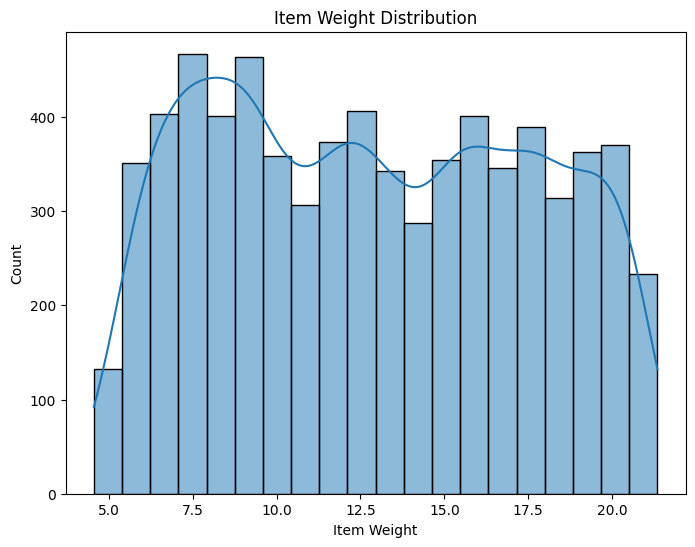

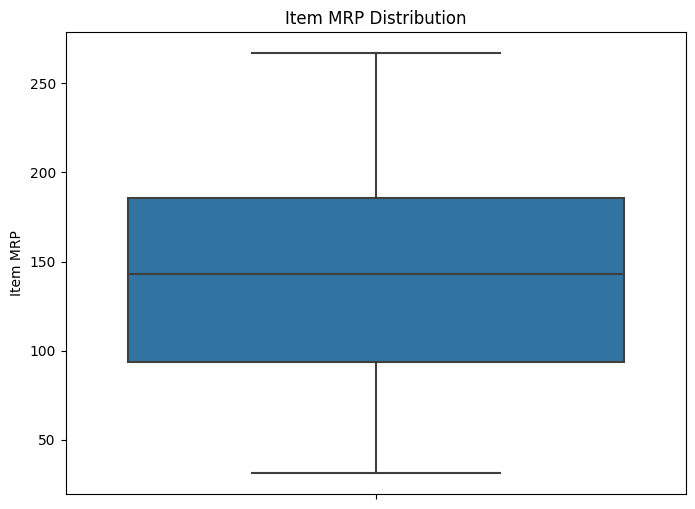

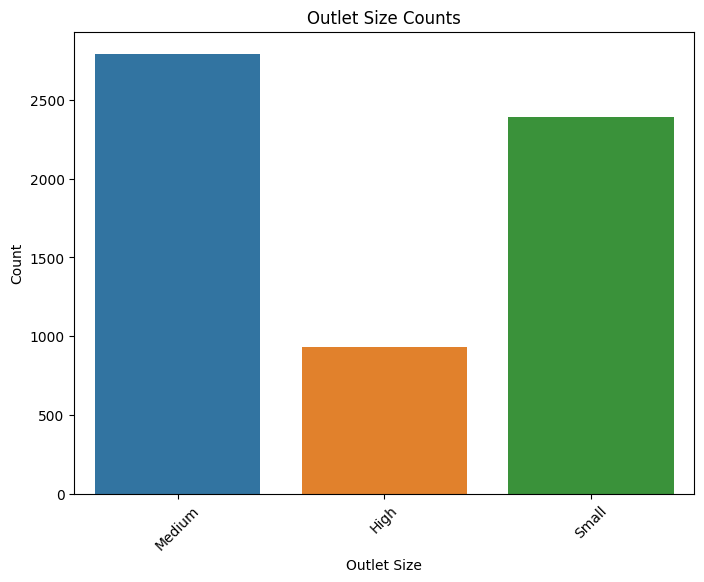

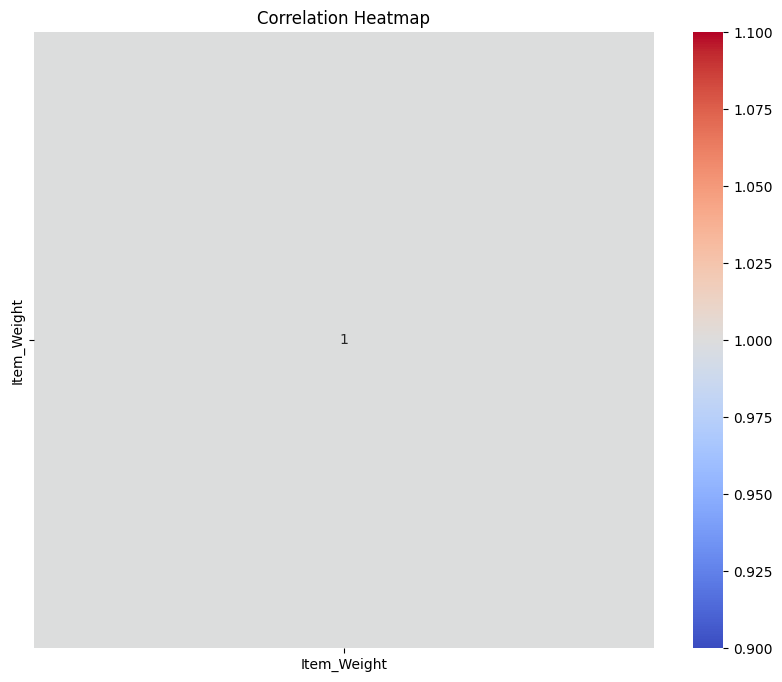

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for a numerical feature
plt.figure(figsize=(8, 6))
sns.histplot(df_filled['Item_Weight'], kde=True)
plt.title('Item Weight Distribution')
plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.show()

# Boxplot for a numerical feature
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_filled['Item_MRP'])
plt.title('Item MRP Distribution')
plt.ylabel('Item MRP')
plt.show()

# Countplot for a categorical feature
plt.figure(figsize=(8, 6))
sns.countplot(data=df_filled, x='Outlet_Size')
plt.title('Outlet Size Counts')
plt.xlabel('Outlet Size')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Heatmap for correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df_filled[numerical_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

You can actually loop  through all of the graphs using the enumerate function I learned it in one of  my classes at school.

## Feature Inspection

In [93]:
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna=True, placeholder='MISSING', figsize=(6, 4), order=None):
    """Creates a seaborn countplot with the option to temporarily fill missing values
    Prints statements about null values, cardinality, and checks for constant/quasi-constant features.
    Source:{PASTE IN FINAL LESSON LINK}
    """
    # Make a copy of the dataframe and fillna
    temp_df = df.copy()
    # Before filling nulls, save null value counts and percent for printing
    null_count = temp_df[x].isna().sum()
    null_perc = null_count / len(temp_df) * 100
    # Fillna with placeholder
    if fillna:
        temp_df[x] = temp_df[x].fillna(placeholder)
    # Create figure with desired figsize
    fig, ax = plt.subplots(figsize=figsize)
    # Plotting a count plot
    sns.countplot(data=temp_df, x=x, ax=ax, order=order)
    # Rotate Tick Labels for long names
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # Add a title with the feature name included
    ax.set_title(f"Column: {x}", fontweight='bold')

    # Fix layout and show plot (before print statements)
    fig.tight_layout()
    plt.show()

    # Print null value info
    print(f"- NaN's Found: {null_count} ({round(null_perc, 2)}%)")
    # Print cardinality info
    nunique = temp_df[x].nunique()
    print(f"- Unique Values: {nunique}")
    # First find value counts of feature
    val_counts = temp_df[x].value_counts(dropna=False)
    # Define the most common value
    most_common_val = val_counts.index[0]
    # Define the frequency of the most common value
    freq = val_counts.values[0]
    # Calculate the percentage of the most common value
    perc_most_common = freq / len(temp_df) * 100
    # Print the results
    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common, 2)}%)")
    # Print message if quasi-constant or constant (most common val more than 98% of data)
    if perc_most_common > 98:
        print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
    else:
        print("- Not constant or quasi-constant.")
    return fig, ax


def explore_numeric(df, x, figsize=(6, 5)):
    """Creates a seaborn histplot and boxplot with a shared x-axis,
    Prints statements about null values, cardinality, and checks for constant/quasi-constant features.
    Source:{PASTE IN FINAL LESSON LINK}
    """

    ## Save null value counts and percent for printing
    null_count = df[x].isna().sum()
    null_perc = null_count / len(df) * 100

    ## Making our figure with gridspec for subplots
    gridspec = {'height_ratios': [0.7, 0.3]}
    fig, axes = plt.subplots(nrows=2, figsize=figsize, sharex=True, gridspec_kw=gridspec)
    # Histogram on Top
    sns.histplot(data=df, x=x, ax=axes[0])

    # Boxplot on Bottom
    sns.boxplot(data=df, x=x, ax=axes[1])

    ## Adding a title
    axes[0].set_title(f"Column: {x}", fontweight='bold')

    ## Adjusting subplots to best fill Figure
    fig.tight_layout()

    # Ensure plot is shown before message
    plt.show()

    # Print null value info
    print(f"- NaN's Found: {null_count} ({round(null_perc, 2)}%)")
    # Print cardinality info
    nunique = df[x].nunique()
    print(f"- Unique Values: {nunique}")

    # Get the most common value, its count as # and as %
    most_common_val_count = df[x].value_counts(dropna=False).head(1)
    most_common_val = most_common_val_count.index[0]
    freq = most_common_val_count.values[0]
    perc_most_common = freq / len(df) * 100

    print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common, 2)}%)")

    # Print message if quasi-constant or constant (most common val more than 98% of data)
    if perc_most_common > 98:
        print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
    else:
        print("- Not constant or quasi-constant.")
    return fig, axes

In [94]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6, 4),
                            fillna=True, placeholder='MISSING',
                            order=None):
    """Plots a combination of a seaborn barplot of means combined with
    a seaborn stripplot to show the spread of the data.
    Source:{PASTE IN FINAL LESSON LINK}
    """
    # Make a copy of the dataframe and fillna
    temp_df = df.copy()
    # fillna with placeholder
    if fillna:
        temp_df[x] = temp_df[x].fillna(placeholder)

    # or drop nulls prevent unwanted 'nan' group in stripplot
    else:
        temp_df = temp_df.dropna(subset=[x])
    # Create the figure and subplots
    fig, ax = plt.subplots(figsize=figsize)

    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)

    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3, zorder=0)
    # Rotate xlabels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Add a title
    ax.set_title(f"{x} vs. {y}", fontweight='bold')
    fig.tight_layout()
    return fig, ax


def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6, 4)):
    """Plots a seaborn regplot with Pearson's correlation (r) added
    to the title.
    Source:{PASTE IN FINAL LESSON LINK}
    """
    # Calculate the correlation
    corr = df[[x, y]].corr().round(2)
    r = corr.loc[x, y]

    # Plot the data
    fig, ax = plt.subplots(figsize=figsize)
    scatter_kws = {'ec': 'white', 'lw': 1, 'alpha': 0.8}
    sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

    # Make sure the plot is shown before the print statement
    plt.show()

    return fig, ax

# Item_Identifier

Item_Identifier: Product ID

In [95]:
feature = "Item_Identifier"
df_filled[feature].dtype

dtype('O')

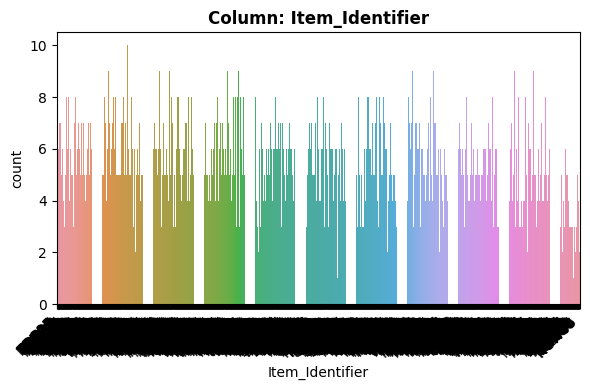

- NaN's Found: 0 (0.0%)
- Unique Values: 1559
- Most common value: 'FDW13' occurs 10 times (0.12%)
- Not constant or quasi-constant.


In [96]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with Undefined

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Yes 1559.

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

No

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Identifier vs. Item_Outlet_Sales'}, xlabel='Item_Identifier', ylabel='Item_Outlet_Sales'>)

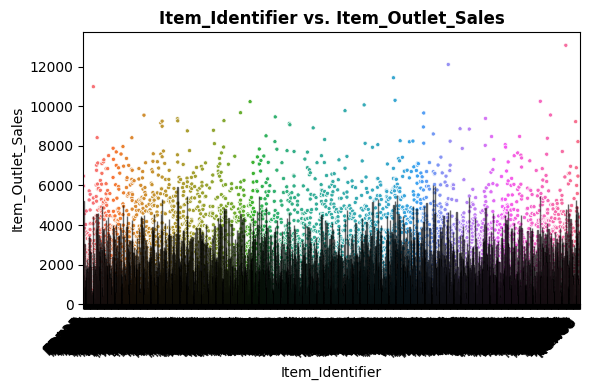

In [97]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - No

# Item_Weight

Item_Weight: Weight of product

In [98]:
feature = "Item_Weight"
df_filled[feature].dtype

dtype('float64')

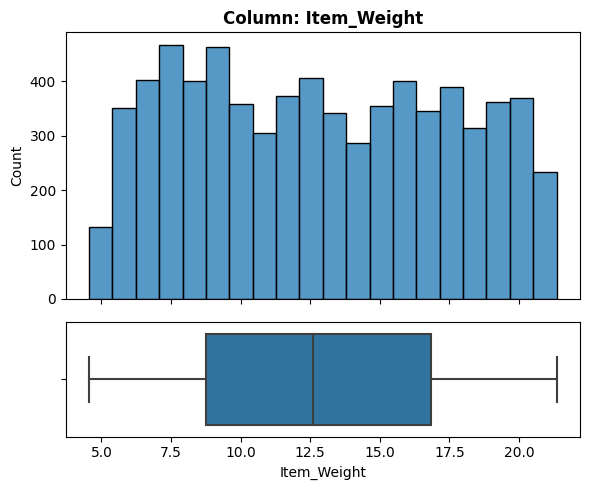

- NaN's Found: 1463 (17.17%)
- Unique Values: 415
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [99]:
explore_numeric(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
numeric.

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

1463 nulls. So the percentage is 17.17%. Impute with the mean

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Not applicable (numeric).

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

No

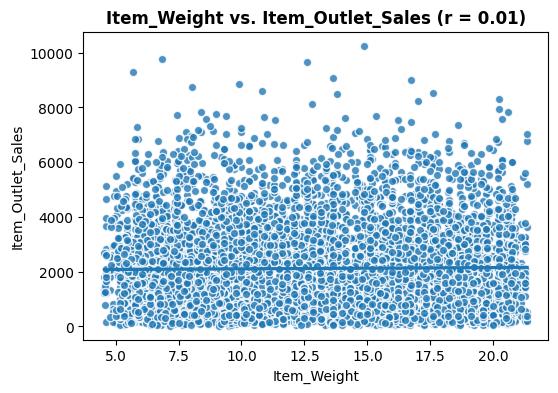

In [100]:
plot_numeric_vs_target(df,feature, 'Item_Outlet_Sales');

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - No

# Item_Fat_Content

Item_Fat_Content: Whether the product is low-fat or regular

In [101]:
feature = "Item_Fat_Content"
df_filled[feature].dtype

dtype('O')

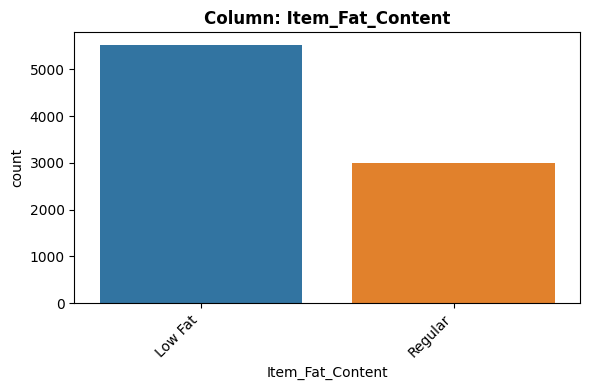

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [102]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric):
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls so 0%. Drop the rows most likely.

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

No, 2 .

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Fat_Content vs. Item_Outlet_Sales'}, xlabel='Item_Fat_Content', ylabel='Item_Outlet_Sales'>)

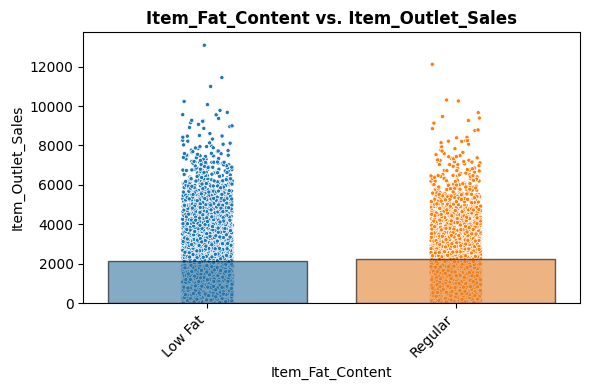

In [103]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - No

# Item_Visibility

Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product

In [104]:
feature = "Item_Visibility"
df_filled[feature].dtype

dtype('float64')

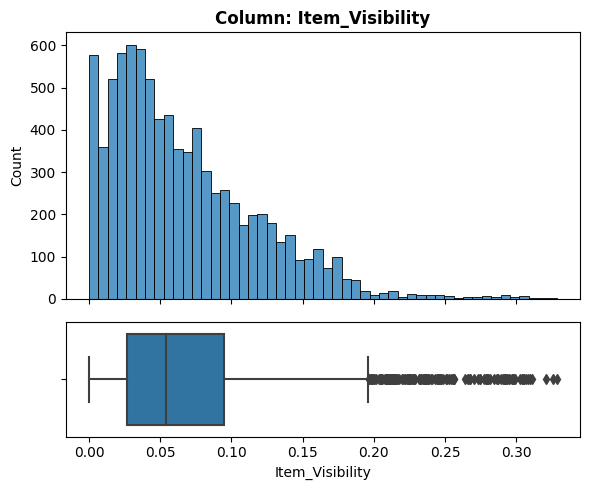

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


In [105]:
explore_numeric(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
numeric.

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with the mean

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Not applicable (numeric).

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

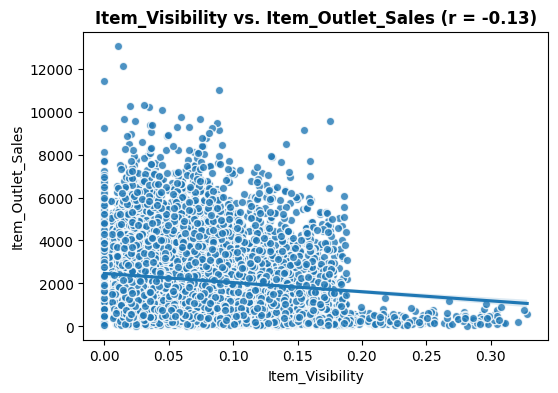

In [106]:
plot_numeric_vs_target(df,feature, 'Item_Outlet_Sales');

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - I am not sure.
  - Does this feature appear to be a predictor of the target?
    - No

# Item_Type

Item_Type: The category to which the product belongs

In [107]:
feature = "Item_Type"
df_filled[feature].dtype

dtype('O')

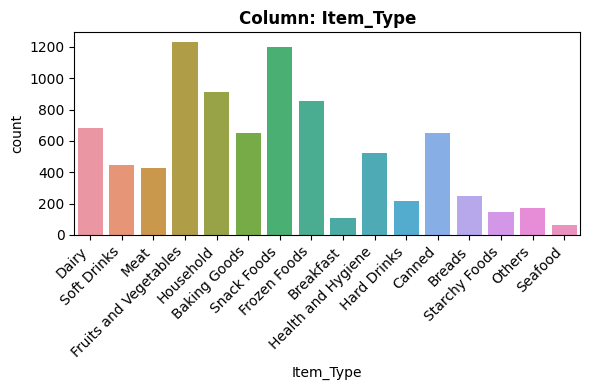

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [108]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with undefined or drop the row

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Yes 16.

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Type vs. Item_Outlet_Sales'}, xlabel='Item_Type', ylabel='Item_Outlet_Sales'>)

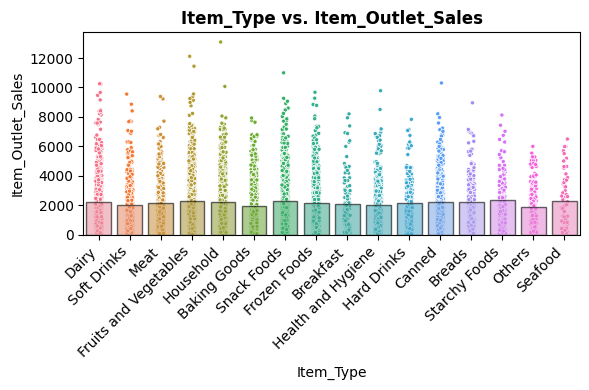

In [109]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - No

# Item_MRP

Item_MRP: Maximum Retail Price (list price) of the product

In [110]:
feature = "Item_MRP"
df_filled[feature].dtype

dtype('float64')

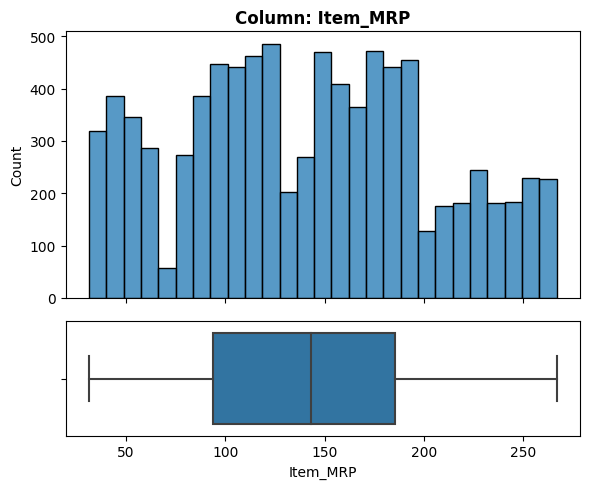

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


In [111]:
explore_numeric(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
numeric.

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with the mean

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Not applicable (numeric).

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

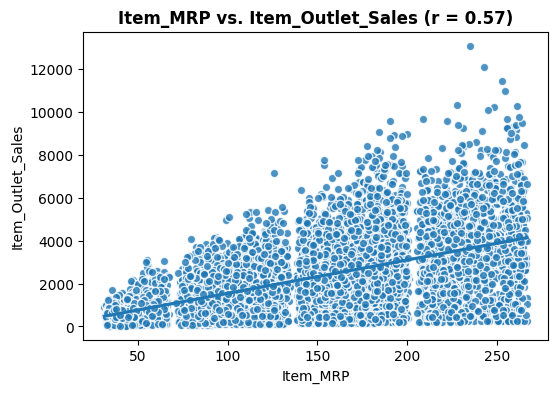

In [112]:
plot_numeric_vs_target(df,feature, 'Item_Outlet_Sales');

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes
  - Does this feature appear to be a predictor of the target?
    - Yes, it seems to be the higher the MRP the higher the ability of it increasing sales.

# Outlet_Identifier

Outlet_Identifier: Store ID

In [113]:
feature = "Outlet_Identifier"
df_filled[feature].dtype

dtype('O')

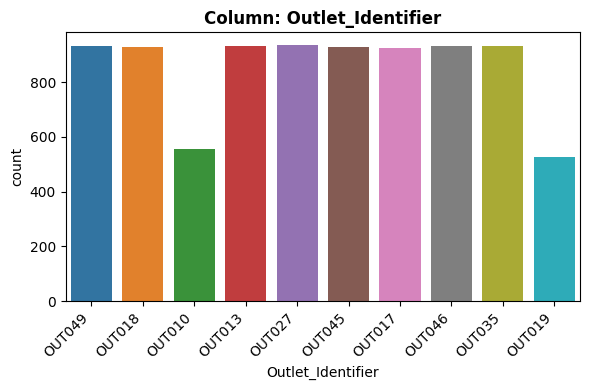

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [114]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with undefined or drop the row

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Yes 10.

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Identifier vs. Item_Outlet_Sales'}, xlabel='Outlet_Identifier', ylabel='Item_Outlet_Sales'>)

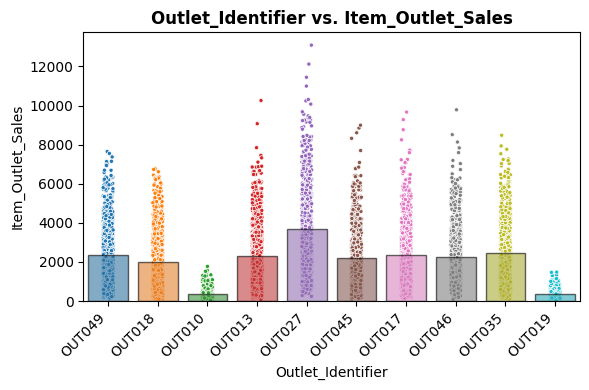

In [115]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - I am not sure.
  - Does this feature appear to be a predictor of the target?
    - No it does not seem to have a relation.

# Outlet_Establishment_Year

Outlet_Establishment_Year: The year in which the store was established

In [116]:
feature = "Outlet_Establishment_Year"
df_filled[feature].dtype

dtype('int64')

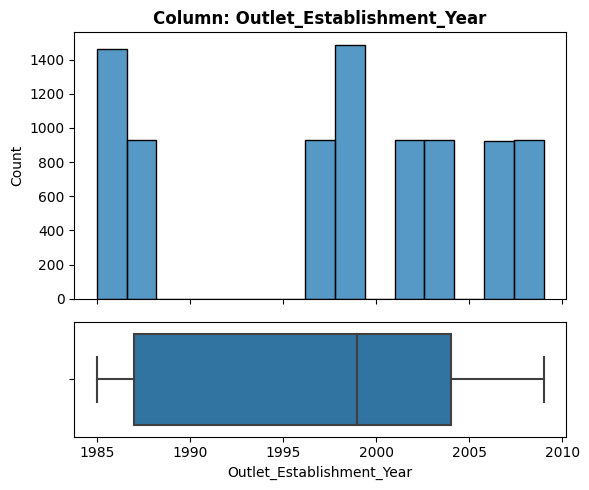

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: '1985' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [117]:
explore_numeric(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
numeric.

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with the mean

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Not applicable (numeric).

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

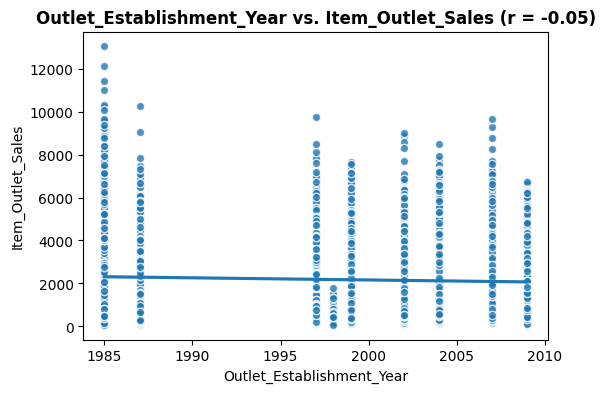

In [118]:
plot_numeric_vs_target(df,feature, 'Item_Outlet_Sales');

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - No there is no correlation

# Outlet_Size

Outlet_Size: The size of the store in terms of ground area covered

In [119]:
feature = "Outlet_Size"
df_filled[feature].dtype

dtype('O')

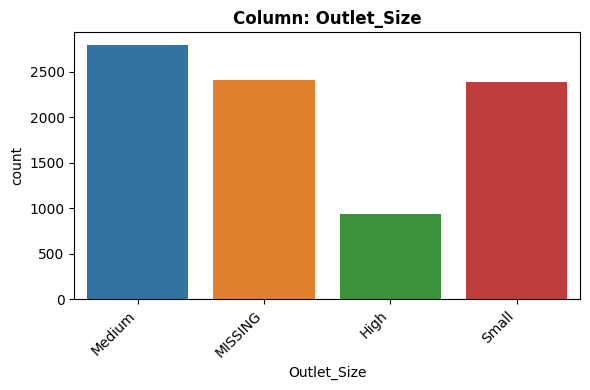

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [120]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

2410 nulls. So the percentage is 28.28%. Impute with undefined

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

No, 4.

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Size vs. Item_Outlet_Sales'}, xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>)

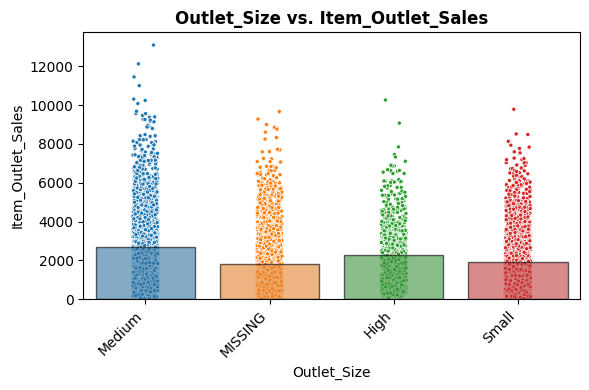

In [121]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - No they seem to not have a huge difference.

# Outlet_Location_Type

Outlet_Location_Type: The type of area in which the store is located

In [122]:
feature = "Outlet_Location_Type"
df_filled[feature].dtype

dtype('O')

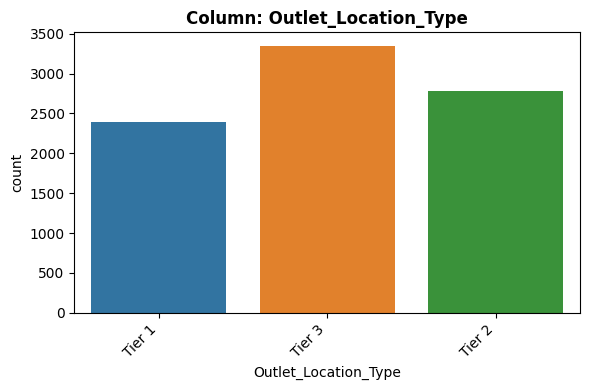

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [123]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with undefined or drop the row

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

No, 3.

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Location_Type vs. Item_Outlet_Sales'}, xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>)

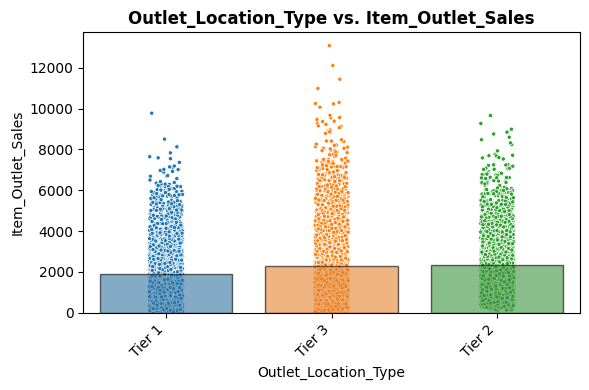

In [124]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Not enough information, but yes location does matter.  
  - Does this feature appear to be a predictor of the target?
    - No all very similar

# Outlet_Type

Outlet_Type: Whether the outlet is a grocery store or some sort of supermarket

In [125]:
feature = "Outlet_Type"
df_filled[feature].dtype

dtype('O')

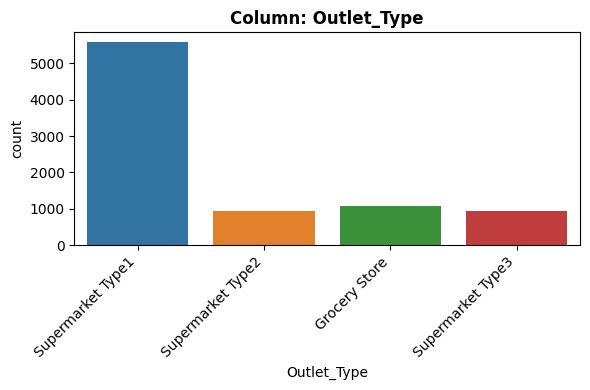

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [126]:
explore_categorical(df_filled,feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Nominal

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with undefined or drop the row

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

No,4.

Would we know this BEFORE the target is determined?

Yes

Is there a business case/understanding reason to exclude based on our business case?

Yes

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Type vs. Item_Outlet_Sales'}, xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>)

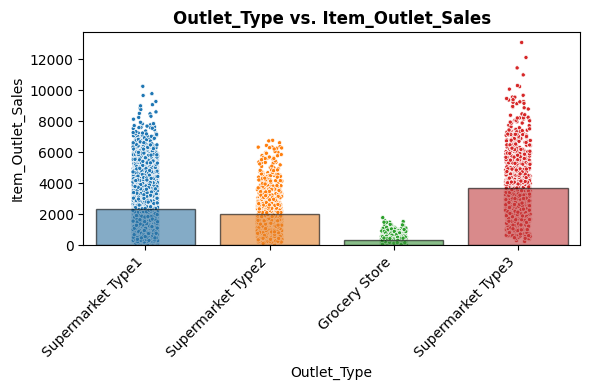

In [127]:
plot_categorical_vs_target(df_filled, feature,'Item_Outlet_Sales')

  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No
  - Does this feature appear to be a predictor of the target?
    - Yes, it seems that being in a Grocery Store leads to lower sales

# Item_Outlet_Sales

In [128]:
feature = "Item_Outlet_Sales"
df_filled[feature].dtype

dtype('float64')

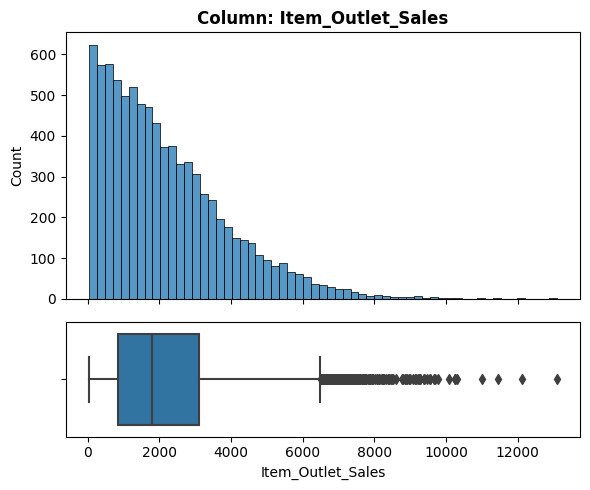

- NaN's Found: 0 (0.0%)
- Unique Values: 3493
- Most common value: '958.752' occurs 17 times (0.2%)
- Not constant or quasi-constant.


In [129]:
explore_numeric(df, feature);

What type of feature is it? (Categorical (nominal), ordinal, numeric)
Numeric

How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)

0 nulls. So the percentage is 0. Impute with the mean

Is the feature constant or quasi-constant?

No.

What is the cardinality? Is it high?

Not applicable (numeric).

Would we know this BEFORE the target is determined?

Yes since it is the Target

Is there a business case/understanding reason to exclude based on our business case?

Yes it is the Target

# Machine Learning

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
numeric_cols = selector(dtype_include='number')(X_train)
categorical_cols = selector(dtype_include='object')(X_train)
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [132]:
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [133]:
preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_pipeline, numeric_cols),
    ('categorical', categorical_pipeline, categorical_cols)
], verbose_feature_names_out=False)

In [134]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [135]:
linear_model = LinearRegression()

In [136]:
linear_model.fit(X_train_processed, y_train)

LinearRegression()

In [137]:
y_train_pred = linear_model.predict(X_train_processed)
y_test_pred = linear_model.predict(X_test_processed)

In [138]:
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return r2, rmse

In [139]:
train_r2, train_rmse = evaluate_model(y_train, y_train_pred)
test_r2, test_rmse = evaluate_model(y_test, y_test_pred)

In [140]:
print(f'Training R-squared: {train_r2:.4f}')
print(f'Test R-squared: {test_r2:.4f}')

Training R-squared: 0.5595
Test R-squared: 0.5793


It is balanced

In [142]:
rf_model = RandomForestRegressor(random_state=42)

In [143]:
rf_model.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

In [144]:
y_train_pred_rf = rf_model.predict(X_train_processed)
y_test_pred_rf = rf_model.predict(X_test_processed)

In [145]:
train_r2_rf, train_rmse_rf = evaluate_model(y_train, y_train_pred_rf)
test_r2_rf, test_rmse_rf = evaluate_model(y_test, y_test_pred_rf)

In [146]:
print("Random Forest Model:")
print(f'Training R-squared: {train_r2_rf:.4f}')
print(f'Test R-squared: {test_r2_rf:.4f}')

Random Forest Model:
Training R-squared: 0.9375
Test R-squared: 0.5703


In [159]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
}

In [153]:
rf_model_tuned = RandomForestRegressor(random_state=42)

In [160]:
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 5], 'n_estimators': [50, 100]})

In [161]:
best_params = grid_search.best_params_

In [169]:
final_rf_model = RandomForestRegressor(random_state=42, **best_params)
final_rf_model.fit(X_train_processed, y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [163]:
y_test_pred_tuned = final_rf_model.predict(X_test_processed)

In [164]:
test_r2_tuned, test_rmse_tuned = evaluate_model(y_test, y_test_pred_tuned)

In [167]:
print(f'Test R-squared: {test_r2_rf:.4f}')
print(f'Test RMSE: {test_rmse_rf:.4f}')
print('\n')
print(f'Test R-squared: {test_r2_tuned:.4f}')
print(f'Test RMSE: {test_rmse_tuned:.4f}')

Test R-squared: 0.5703
Test RMSE: 1080.6490


Test R-squared: 0.6171
Test RMSE: 1020.2148


The Performance Improved.

I would recommend using the tuned Random Forest Model for the model to predict the sales.

The the tuned random Forest model the R-Squared value of .6171 means that around 61.71% of the variability in the sales can be determined by the data used in the model.

We can use RMSE because it can show us how far off the models predictions are from the actual sales and we can use it to improve.

I used RMSE because it can measure the models accuracy in prediting the sales values.

The Model is balanced so not overfit or underfit.